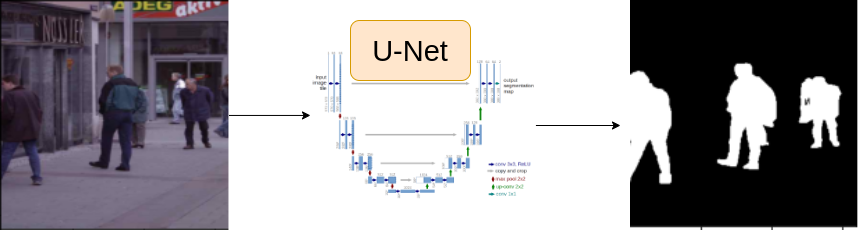

# Some Common Imports

In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [4]:
CSV_FILE = 'train.csv'
DATA_DIR = '/'

DEVICE = 'cpu' if not torch.cuda.is_available() else 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Ground_Truth/1.png,Training_Images/1.jpg
1,Ground_Truth/10.png,Training_Images/10.jpg
2,Ground_Truth/100.png,Training_Images/100.jpg
3,Ground_Truth/101.png,Training_Images/101.jpg
4,Ground_Truth/102.png,Training_Images/102.jpg


In [6]:
# get the first image at position 0 for visualization
row = df.iloc[0]

# use the .images attritute to get values and masks
image_path = row.images
mask_path = row.masks

# open cv2 to read the images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

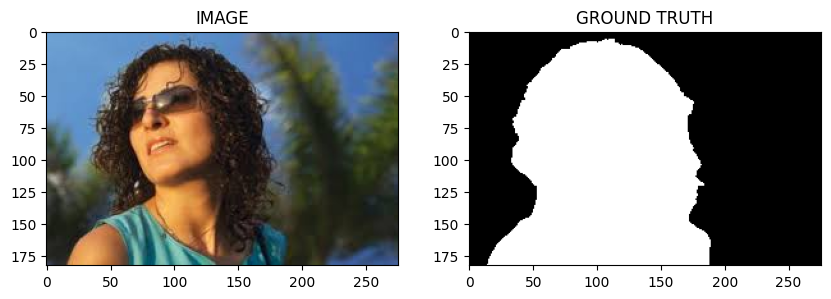

In [7]:
# Visualise the image and it ground truth
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(masks,cmap = 'gray');


In [8]:
# split the dataset into training and validation
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [9]:
# import library for augmentation
import albumentations as A

/Users/bhanuprasadcherukuvada/uni/ml/human-segmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# function for training dataset augmentation
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ])


# function for validation dataset augmentation
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

# Task 4 : Create Custom Dataset

In [11]:
from torch.utils.data import Dataset

In [12]:
class SegmentationDataset(Dataset):

  # the initial method for the dataframe and augmentation
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  # length of the dataframe
  def __len__(self):
    return len(self.df)

  # get item the image attributes
  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if image.shape != mask.shape:
            # Resize or crop either image or mask to match dimensions
            # Example:
            image = cv2.resize(image, (mask.shape[1], mask.shape[0]))

    data = self.augmentations(image=image, mask=mask)
    image = data['image']
    mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)


    # convert from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [13]:
# now call the SegmentationDataset class to augment the train_df and valid_df
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [14]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


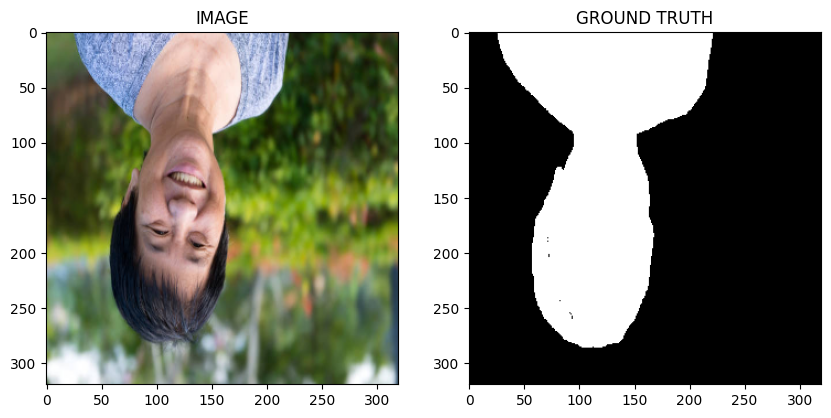

In [15]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [16]:
from torch.utils.data import DataLoader

In [17]:
# load dataset with dataloader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [18]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 15
Size of Validloader : 4


In [19]:
for image, mask in trainloader:
  break
print(f"Image shape : {image.shape}")
print(f"Mask shape : {mask.shape}")

Image shape : torch.Size([16, 3, 320, 320])
Mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [20]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [21]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask = None):

    logits = self.arc(images)

    if mask is not None:
      loss1 = DiceLoss(mode="binary")(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [22]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /Users/bhanuprasadcherukuvada/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 12.3MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [23]:
def train_fn(model, dataloader, optimizer):
  model.train()
  train_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(dataloader)

In [24]:
def eval_fn(model, dataloader):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

# Task 8 : Train Model

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [26]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"EPOCH : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:16<00:00,  4.25s/it]


SAVED-MODEL
EPOCH : 1 | Train Loss : 0.7975776235262553 | Valid Loss : 4.5047783851623535


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]


SAVED-MODEL
EPOCH : 2 | Train Loss : 0.3861979862054189 | Valid Loss : 0.38370078429579735


 13%|█▎        | 2/15 [00:53<05:45, 26.60s/it]

# Task 9 : Inference

In [ ]:
def inference(indx):
  idx = indx

  model.load_state_dict(torch.load('/content/best_model.pth'))

  image, mask = validset[idx]


  logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5)*1.0

  return helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

<ipython-input-28-4d9074086fc7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


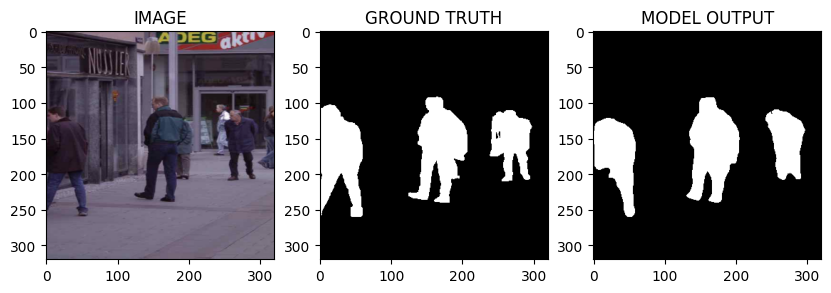

In [ ]:
inference(20)